In [146]:
# !pip install dataframe_image

In [147]:
import pandas as pd
from scripts import helper
import matplotlib.pyplot as plt
import dataframe_image as dfi
import numpy as np

pd.set_option('display.max_columns', None)

In [148]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [149]:
mnist_lf_unt = pd.read_csv('wandb_export_2023-06-14_lf_untargeted.csv')

In [150]:
# Fix missing attack_env
mnist_lf_unt['adversarial_args.attack_env.poisoned_sample_percent'] = mnist_lf_unt['Group'].str.extract(r'-S(.*)_R')
mnist_lf_unt['adversarial_args.attack_env.poisoned_sample_percent'].unique()
mnist_lf_unt = mnist_lf_unt.astype({'adversarial_args.attack_env.poisoned_sample_percent': 'int64'})
# Sanity check
print(mnist_lf_unt["adversarial_args.attack_env.poisoned_sample_percent"].unique())
print(mnist_lf_unt["adversarial_args.attack_env.poisoned_node_percent"].unique())

[ 30  50 100]
[10 50 80]


In [151]:
benign = mnist_lf_unt[mnist_lf_unt['adversarial_args.attacks'] == 'No Attack']

mean_benign = pd.pivot_table(benign, index=["aggregator_args.algorithm",
                                         "adversarial_args.attack_env.attack",
                                         "adversarial_args.attack_env.poisoned_node_percent",
                                         "adversarial_args.attack_env.poisoned_sample_percent",],
                          values=["Test/Accuracy","Test/F1Score"], aggfunc = 'mean', dropna=False)
mean_benign = mean_benign.reset_index()
# mean_benign.columns = mean_benign.columns.map('_'.join)
mean_benign

,aggregator_args.algorithm,adversarial_args.attack_env.attack,adversarial_args.attack_env.poisoned_node_percent,adversarial_args.attack_env.poisoned_sample_percent,Test/Accuracy,Test/F1Score
0,FedAvg,Label Flipping,10,30,0.957591,0.954829
1,FedAvg,Label Flipping,10,50,0.953355,0.950430
2,FedAvg,Label Flipping,10,100,0.956286,0.953764
3,FedAvg,Label Flipping,50,30,0.952649,0.948337
4,FedAvg,Label Flipping,50,50,0.950868,0.947347
5,FedAvg,Label Flipping,50,100,0.873856,0.860022
6,FedAvg,Label Flipping,80,30,0.929406,0.923028
7,FedAvg,Label Flipping,80,50,0.910986,0.902630
8,FedAvg,Label Flipping,80,100,0.044741,0.038232
9,FlTrust,Label Flipping,10,30,0.914563,0.906115


In [152]:
# Sanity check
num_attack_configs = len(mean_benign.index)
assert num_attack_configs == 45

In [153]:
overview_f1 = mean_benign.pivot(columns=["adversarial_args.attack_env.poisoned_node_percent", "adversarial_args.attack_env.poisoned_sample_percent"],
                               index=["aggregator_args.algorithm"],
                               values="Test/F1Score")

overview_f1 = overview_f1.rename(columns={'adversarial_args.attack_env.poisoned_node_percent': 'poisoned_node_percent'})
overview_f1_style = overview_f1.style.set_caption("Label Flipping Untargeted: F1 Score")
overview_f1_style.highlight_max()
dfi.export(overview_f1_style,"overview_f1.png")
overview_f1_style

In [154]:
overview_acc = mean_benign.pivot(columns=["adversarial_args.attack_env.poisoned_node_percent", "adversarial_args.attack_env.poisoned_sample_percent"],
                                index=["aggregator_args.algorithm"],
                                values="Test/Accuracy")

overview_acc = overview_acc.rename(columns={'adversarial_args.attack_env.poisoned_node_percent': 'poisoned_node_percent'})
overview_acc_style = overview_acc.style.set_caption("Label Flipping Untargeted: Accuracy")
overview_acc_style.highlight_max()
dfi.export(overview_acc_style,"overview_acc.png")
overview_acc_style

In [155]:
def get_plot_by_node_percent(data=None, data_std=None, fig=None, y_col=None, plt_title='No Title'):

    df = data[['aggregator_args.algorithm', 'adversarial_args.attack_env.poisoned_node_percent', y_col]]
    #fig = plt.figure(figsize=(8, 6))
    fig = plt.figure()
    marker_styles = ['+', 'x', 'o']
    line_styles = ['-', '--', '-.', ':', '-']
    ax = None

    # Plot each aggregator's data
    for i, (aggregator, data) in enumerate(df.groupby('aggregator_args.algorithm')):
        df_agg = df[df['aggregator_args.algorithm'] == aggregator]
        ax = df_agg.plot(x='adversarial_args.attack_env.poisoned_node_percent',
                         y=y_col,
                         marker=marker_styles[i % len(marker_styles)],
                         markersize=6,
                         linestyle=line_styles[i % len(line_styles)],
                         linewidth=1,
                         label=aggregator,
                         ax=ax)

    # Set plot title and labels
    plt.title(plt_title, fontsize=10)
    plt.xlabel("Poisoned Node Percent", fontsize=10)
    plt.ylabel(y_col, fontsize=10)
    plt.ylim(0,1)

    # Set legend
    plt.legend(fontsize=10)

    # Set grid
    plt.grid(True, linestyle='--', alpha=0.5)

    # Increase tick font sizes
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    return fig


<Figure size 640x480 with 0 Axes>

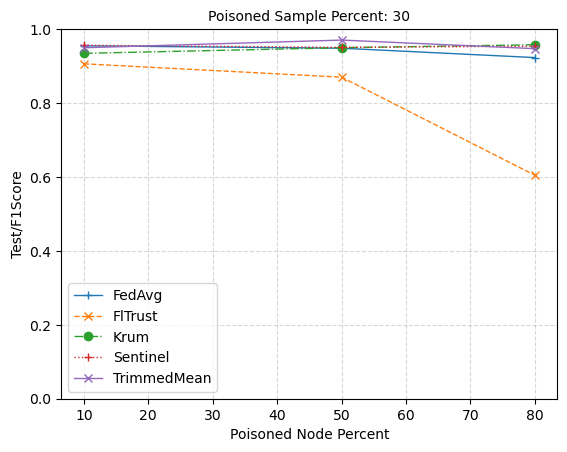

<Figure size 640x480 with 0 Axes>

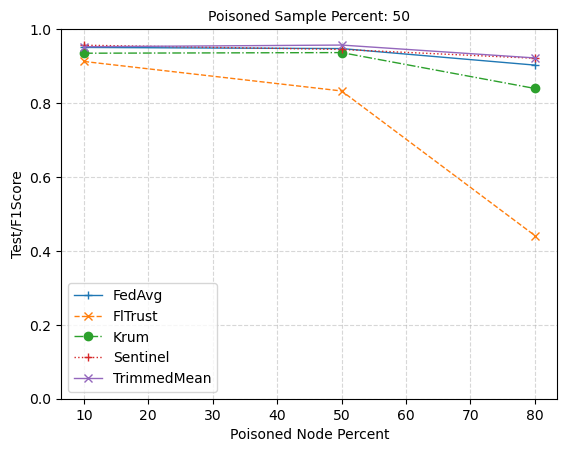

<Figure size 640x480 with 0 Axes>

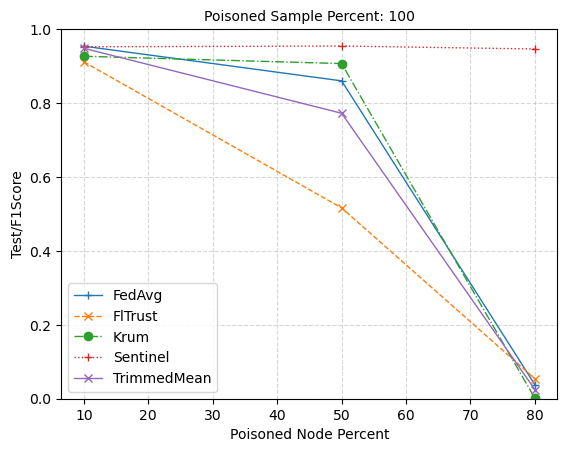

In [156]:
sample_percents = mean_benign['adversarial_args.attack_env.poisoned_sample_percent'].unique()

for percent in sample_percents:
    data_by_percent = mean_benign[mean_benign['adversarial_args.attack_env.poisoned_sample_percent'] == percent]
    plt_title = "Poisoned Sample Percent: " + str(percent)

    # percent_f1 = helper.get_plot_by_node_percent(data=data_by_percent, y_col='Test/F1Score', plt_title=str(percent))
    percent_acc = get_plot_by_node_percent(data=data_by_percent, y_col='Test/F1Score', plt_title=plt_title)
    plt.savefig(f'lf-plot-{percent}.png')